In [1]:
import dreye
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get dummy LED measurements and a photoreceptor model

In [2]:
sns.set_theme(
    style='ticks', 
    context='talk',
)

In [3]:
wls = np.arange(300, 651)

In [4]:
np.random.seed(10)
peaks = np.linspace(350, 580, 7)
leds = dreye.create_gaussian_spectrum(
    wls, 
    peaks, 
    np.array([7, 10, 18, 25, 38, 31, 28])
    # (np.random.random(peaks.size) + 0.3) * 10
)

In [5]:
intensity_bounds=(
    np.zeros(peaks.size), 
    np.array([10, 12, 17, 22, 25, 28, 60])
    # (np.random.random(peaks.size) + 0.5) * 10
)
measured_spectra = dreye.get_led_spectra_container(
    leds,
    names=['duv', 'uv', 'violet', 'blue', 'cyan', 'green', 'amber'], 
    intensity_bounds=intensity_bounds, 
    output_bounds=(0, 5)
)

## Spectra of LEDs used for fitting

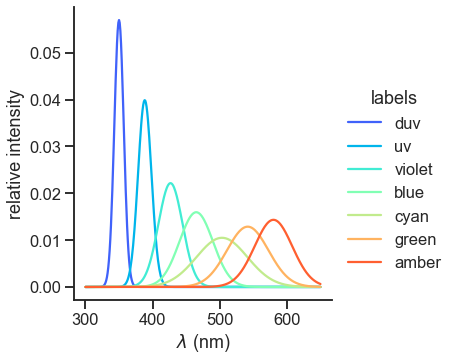

In [6]:
measured_spectra.normalized_spectra.plot(palette='rainbow')
plt.ylabel('relative intensity')
plt.savefig('light_sources.pdf')

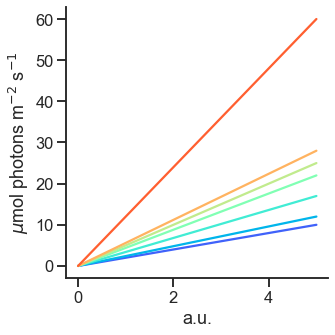

In [7]:
measured_spectra.intensities.plot(palette='rainbow', legend=False)
plt.ylabel(r'$\mu$mol photons m$^{-2}$ s$^{-1}$')
plt.tight_layout()
plt.savefig('light_source_intensities.pdf')

In [8]:
# intensity range of LEDs
measured_spectra.intensity_bounds

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([10., 12., 17., 22., 25., 28., 60.]))

## Trichromatic linear photoreceptor model

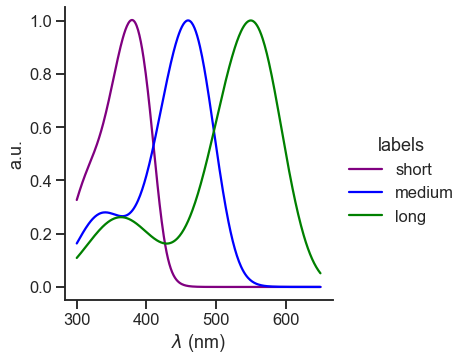

In [9]:
cmap = {'short': 'purple', 'medium': 'blue', 'long': 'green'}
peaks = np.array([380, 460, 550])
sensitivity1 = dreye.Sensitivity(
    peaks, 
    wls, 
    from_template=True, 
    labels=list(cmap), 
    name='animal1'
)
sensitivity1.plot(palette=cmap)

In [10]:
pr_model1 = dreye.LinearPhotoreceptor(sensitivity1)

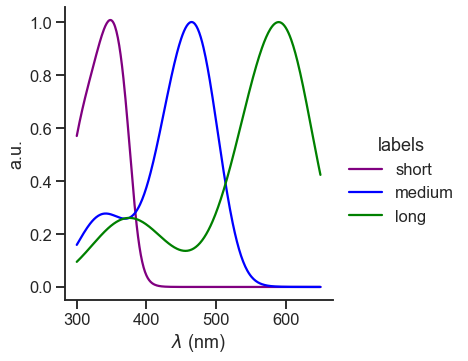

In [11]:
sensitivity2 = dreye.Sensitivity(
    peaks+np.array([-30, 5, +40]), 
    wls, 
    from_template=True, 
    labels=list(cmap), 
    name='animal2'
)
sensitivity2.plot(palette=cmap)

In [12]:
pr_model2 = dreye.LinearPhotoreceptor(sensitivity2)

In [13]:
metrics1 = dreye.MeasuredSpectraMetrics(
    4, 
    pr_model1, measured_spectra
)
metrics2 = dreye.MeasuredSpectraMetrics(
    4, 
    pr_model2, measured_spectra
)

In [ ]:
metrics1.

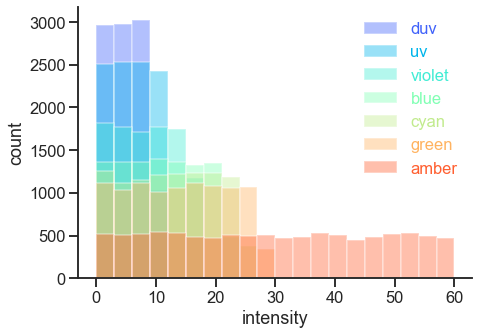

In [14]:
plt.figure(figsize=(7, 5))
lcolors = sns.color_palette('rainbow', len(measured_spectra))
for arr, color, label in zip(metrics1.random_samples.T, lcolors, measured_spectra.names):
    plt.hist(
        arr,
        bins=20, 
        range=(0, 60), 
        alpha=0.4, 
        color=color, 
        label=label,
    )
    
plt.ylabel('count')
plt.xlabel('intensity')
plt.legend(frameon=False, labelcolor=lcolors)
sns.despine()
plt.tight_layout()
plt.savefig('random_points_LEDS.pdf')


In [15]:
# sns.pairplot(
#     pd.DataFrame(metrics1.random_samples, columns=measured_spectra.names), 
#     plot_kws=dict(color='gray'), 
#     corner=True, 
#     diag_kind=False
# )
# plt.savefig('random_intensities.pdf')

In [22]:
df_mw = metrics1.get_excitation_metrics(
    metric='mean_width',
    normalize=True
)
df_v = metrics1.get_excitation_metrics(
    metric='volume',
    normalize=True
)
df_cc = metrics1.get_excitation_metrics(
    metric='corr'
)
df_cc['metric'] = 1 - df_cc['metric']
df_gamut = metrics1.compute_gamuts()
df1 = pd.concat([df_mw, df_v, df_cc, df_gamut])

In [23]:
df_mw = metrics2.get_excitation_metrics(
    metric='mean_width',
    normalize=True
)
df_v = metrics2.get_excitation_metrics(
    metric='volume',
    normalize=True
)
df_cc = metrics2.get_excitation_metrics(
    metric='corr'
)
df_cc['metric'] = 1 - df_cc['metric']
df_gamut = metrics2.compute_gamuts()
df2 = pd.concat([df_mw, df_v, df_cc, df_gamut])

In [28]:
set1 = df1.set_index('light_combos').groupby('metric_name')['metric'].nlargest(5)
set1.name = 'metric'
set1 = set1.reset_index()
set1['name'] = 'animal1'
set2 = df2.set_index('light_combos').groupby('metric_name')['metric'].nlargest(5)
set2.name = 'metric'
set2 = set2.reset_index()
set2['name'] = 'animal2'
best_set = pd.concat([set1, set2])
best_set['LEDs'] = best_set['light_combos'].str.replace('+', '\n+', regex=False)

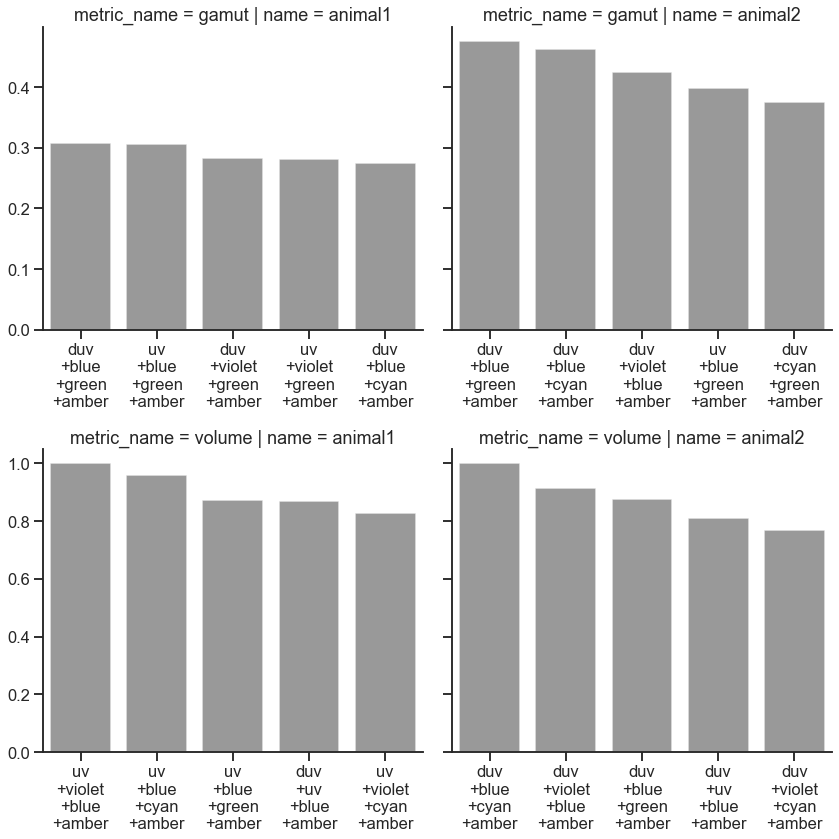

In [33]:
g = sns.FacetGrid(
    data=best_set[best_set['metric_name'].isin(['gamut', 'volume'])], 
    sharex=False, 
    sharey='row', 
    col='name',
    row='metric_name',
    aspect=1, height=6
)
g.map_dataframe(
    sns.barplot, 
    x='LEDs', 
    y='metric',
    color='gray', 
    alpha=0.8
)
plt.savefig('metrics_results.pdf')